In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader
from torch import optim

In [ ]:
# read the data, make a df of 150 instances
df1 = pd.read_excel('results/SA/100ex30-SA100/output_100e_100.xlsx')
df2 = pd.read_excel('results/SA/100ex20-SA200/output_100e_200-101to200.xlsx')
df12 = pd.concat([df1, df2])
# from df2, keep instance 101-150
df = df12[df12['instance'] < 151]

# drop the columns that are not needed
df = df.drop(columns=['neighborhood_size', 'neighbor_deviation_scale', 'vessel_time_window', 'affected_movements', 'time_interval','epochs'])
# rename number of movements to movements reached
df = df.rename(columns={'number of movements': 'movements reached'})
col_names = df.columns
print(col_names)

df_instances = pd.read_excel('results/instanceData_200.xlsx')
col_names_instances = df_instances.columns
print(col_names_instances)
# merge the two dataframes
df = pd.merge(df, df_instances, on='instance')


In [5]:
# recalculate the objective function
movements_factor = 0.001
headway_factor = 0.001
df['objective_function'] = df['average delay'] \
                           + df['movements reached'] * movements_factor + df['number_of_headways'] * headway_factor
print(df['objective_function'], df['average delay'])

0       1.090667
1       1.257333
2       1.469833
3       1.140667
4       1.278167
          ...   
3995    1.424485
3996    0.988879
3997    1.170697
3998    1.079788
3999    1.598727
Name: objective_function, Length: 4000, dtype: float64 0       0.666667
1       0.833333
2       1.045833
3       0.716667
4       0.854167
          ...   
3995    0.848485
3996    0.412879
3997    0.594697
3998    0.503788
3999    1.022727
Name: average delay, Length: 4000, dtype: float64


In [6]:
feature_cols= ['t0', 'alpha',
               'number_of_movements', 'number_of_vessels', 'average_headway', 'std_dev_headway', 'spread',
                'average_time_between_movements', 'average_travel_time']

X = df[feature_cols].values
y = df['objective_function'].values

In [89]:
# import warnings
# warnings.filterwarnings("ignore")
# 
# # Convert data to torch tensors
# class Data(Dataset):
#     def __init__(self, X, y):
#         self.X = X.astype(np.float32)
#         self.y = y.astype(np.float32)
#         # or directly from pandas to torch
#         X = torch.from_numpy(X)
#         y = torch.from_numpy(y)
#         self.len = self.X.shape[0]
#        
#     def __getitem__(self, index):
#         return self.X[index], self.y[index]
#    
#     def __len__(self):
#         return self.len
# 
# # Define batch size
# batch_size = 32
# 
# # Instantiate training and test data
# train_data = Data(X_train_scaled, y_train_scaled)
# train_dataloader = DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True)
# 
# test_data = Data(X_test_scaled, y_test_scaled)
# test_dataloader = DataLoader(dataset=test_data, batch_size=batch_size, shuffle=True)
# 
# # Check it's working
# for batch, (X, y) in enumerate(train_dataloader):
#     print(f"Batch: {batch+1}")
#     print(f"X shape: {X.shape}")
#     print(f"y shape: {y.shape}")
#     break


In [7]:
# define the network
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(9, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 1)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.fc3(x)
    
model = Net()
# to cuda
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)
print(model)

Net(
  (fc1): Linear(in_features=9, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=1, bias=True)
)


In [8]:
import tqdm

# loss function and optimizer
loss_fn = nn.MSELoss()  # mean square error
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# train-test split of the dataset
X_train_raw, X_test_raw, y_train, y_test = train_test_split(X, y, train_size=0.8, shuffle=True)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_raw)
X_test_scaled = scaler.transform(X_test_raw)


X_train = torch.tensor(X_train_scaled, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32).reshape(-1, 1)
X_test = torch.tensor(X_test_scaled, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32).reshape(-1, 1)
 
# training parameters
n_epochs = 300   # number of epochs to run
batch_size = 40  # size of each batch
batch_start = torch.arange(0, len(X_train), batch_size)
 
# Hold the best model
best_mse = np.inf   # init to infinity
best_weights = None
history = []
 
# training loop
for epoch in range(n_epochs):
    model.train()
    with tqdm.tqdm(batch_start, unit="batch", mininterval=0, disable=True) as bar:
        bar.set_description(f"Epoch {epoch}")
        for start in bar:
            # take a batch
            X_batch = X_train[start:start+batch_size]
            y_batch = y_train[start:start+batch_size]
            # forward pass
            y_pred = model(X_batch)
            loss = loss_fn(y_pred, y_batch)
            # backward pass
            optimizer.zero_grad()
            loss.backward()
            # update weights
            optimizer.step()
            # print progress
            bar.set_postfix(mse=float(loss))
            if epoch % 10 == 0:
                history.append(float(loss))
                print(f"Epoch: {epoch}, Loss: {loss.item():.4f}")
    # evaluate accuracy at end of each epoch
    model.eval()
    y_pred = model(X_test)
    mse = loss_fn(y_pred, y_test)
    mse = float(mse)
    history.append(mse)
    if mse < best_mse:
        best_mse = mse
        best_weights = model.state_dict().copy()
 
# restore model and return best accuracy
model.load_state_dict(best_weights)

Epoch: 0, Loss: 2.0011
Epoch: 0, Loss: 2.0398
Epoch: 0, Loss: 2.0082
Epoch: 0, Loss: 1.7078
Epoch: 0, Loss: 1.9745
Epoch: 0, Loss: 1.8531
Epoch: 0, Loss: 1.7747
Epoch: 0, Loss: 1.7987
Epoch: 0, Loss: 1.8352
Epoch: 0, Loss: 2.1034
Epoch: 0, Loss: 1.6943
Epoch: 0, Loss: 1.8849
Epoch: 0, Loss: 1.5442
Epoch: 0, Loss: 1.9286
Epoch: 0, Loss: 1.7335
Epoch: 0, Loss: 1.5584
Epoch: 0, Loss: 1.8865
Epoch: 0, Loss: 1.6786
Epoch: 0, Loss: 1.6481
Epoch: 0, Loss: 1.8207
Epoch: 0, Loss: 1.5884
Epoch: 0, Loss: 1.7916
Epoch: 0, Loss: 1.5746
Epoch: 0, Loss: 1.7811
Epoch: 0, Loss: 1.7253
Epoch: 0, Loss: 1.6145
Epoch: 0, Loss: 1.4338
Epoch: 0, Loss: 1.4185
Epoch: 0, Loss: 1.4454
Epoch: 0, Loss: 1.8335
Epoch: 0, Loss: 1.6152
Epoch: 0, Loss: 1.6360
Epoch: 0, Loss: 1.5343
Epoch: 0, Loss: 1.7549
Epoch: 0, Loss: 1.4433
Epoch: 0, Loss: 1.4391
Epoch: 0, Loss: 1.7672
Epoch: 0, Loss: 1.5548
Epoch: 0, Loss: 1.5785
Epoch: 0, Loss: 1.6270
Epoch: 0, Loss: 1.4878
Epoch: 0, Loss: 1.4771
Epoch: 0, Loss: 1.5174
Epoch: 0, L

<All keys matched successfully>

MSE: 0.05
RMSE: 0.22


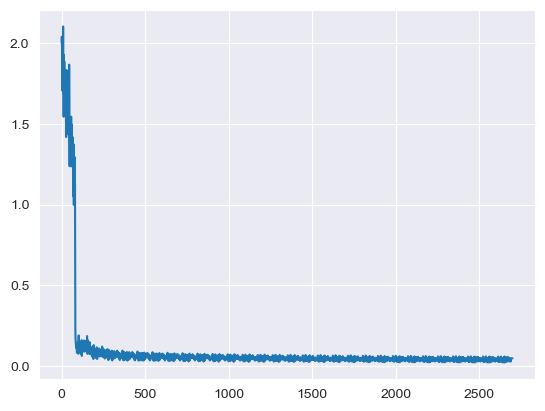

In [9]:
# plot the loss
import matplotlib.pyplot as plt

model.load_state_dict(best_weights)
print("MSE: %.2f" % best_mse)
print("RMSE: %.2f" % np.sqrt(best_mse))
plt.plot(history)
plt.show()

In [10]:
model.eval()
with torch.no_grad():
    # Test out inference with 5 samples from the original test set
    for i in range(5):
        X_sample = X_test_raw[i: i+1]
        X_sample = scaler.transform(X_sample)
        X_sample = torch.tensor(X_sample, dtype=torch.float32)
        y_pred = model(X_sample)
        print(f"{X_test_raw[i]} -> {y_pred[0].numpy()} (expected {y_test[i].numpy()})")

[467.           0.89628703  22.          20.           0.77894328
   0.49337179  27.83333333   1.26515152   2.17424242] -> [1.3226697] (expected [1.045697])
[297.           0.75204936  19.          18.           0.78379065
   0.51889008  22.16666667   1.16666667   2.0745614 ] -> [1.0417414] (expected [0.6671754])
[199.           0.98972809  18.          17.           0.87428337
   0.54374122  19.25         1.06944444   2.02777778] -> [1.1967541] (expected [0.8648148])
[478.           0.5440883   24.          22.           0.78097063
   0.51242933  22.83333333   0.95138889   2.42361111] -> [1.4020976] (expected [1.5494722])
[425.           0.88858135  19.          16.           0.84850187
   0.57211328  15.08333333   0.79385965   2.0877193 ] -> [1.2625684] (expected [1.1569824])


In [1]:
# plot the predictions as a scatter plot
y_pred = model(X_test)
y_pred = y_pred.detach().numpy()
plt.scatter(y_test, y_pred)
plt.xlabel("True Values")
plt.ylabel("Predictions")
# plot the line of best fit
z = np.polyfit(y_pred[0], y_test[0], 1)
p = np.poly1d(z)
plt.plot(y_test,p(y_test),"r--")
# plot the line y=x
plt.plot(y_test, y_test, 'g--')
plt.show()



NameError: name 'model' is not defined

In [95]:
# get the importance of each feature
importance = model.fc1.weight.data.numpy()
# summarize feature importance
for i,v in enumerate(importance[0]):
    print('Feature: %0d, Score: %.5f' % (i,v))

Feature: 0, Score: 0.16279
Feature: 1, Score: -0.04942
Feature: 2, Score: 0.14793
Feature: 3, Score: 0.05046
Feature: 4, Score: 0.26305
Feature: 5, Score: -0.04709
Feature: 6, Score: 0.07518
Feature: 7, Score: 0.17553
Feature: 8, Score: 0.35536


In [13]:
# save the model
torch.save(model.state_dict(), 'results/SA/models/NN_model_150e.pth')

# save the scaler
import pickle
pickle.dump(scaler, open('results/SA/models/scaler_150e.pkl', 'wb'))